In [ ]:
#algorithms needed: upscaling methods, ksvdbox, ompbox

In [279]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import math
from sklearn.linear_model import Lasso

In [1]:
imgscale = 1
flag = 0
upscaling = 3
clusterszA = 2048

In [51]:
#zeyde configurations
zeyde_conf = scipy.io.loadmat('conf_Zeyde_16_finalx3.mat')
print(len(zeyde_conf['conf'][0][0]))
dict_lores = zeyde_conf['conf'][0][0][10]
dict_hires = zeyde_conf['conf'][0][0][11]
print(dict_lores.shape)
print(dict_hires.shape)

llambda = 0.01

13
(30, 16)
(81, 16)


# Yi Ma implementation

In [244]:
#res{2} = {yima(low{1}, upscaling)}


patch_size = 3 #patch size for the low resolution input image
#overlap = 2; % overlap between adjacent patches
#lambda = 0.1; % sparsity parameter
#zooming = 3; % zooming factor, if you change this, the dictionary needs to be retrained. #upscaling = 3

#disp('Start superresolution...');
#ReconIm = L1SR(lowIm, zooming, patch_size, overlap, Dh, Dl, lambda, regres);

zooming = 3

In [245]:
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))



def show_image(img):
    
    img = np.clip(img,a_min=0,a_max=255)
    print(np.max(img))
    
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)

    if len(img.shape)==3 and img.shape[2]==3:
        imgplot = ax1.imshow(img)
    elif len(img.shape)==2:
        imgplot = ax1.imshow(img,cmap='gray')

    plt.show()

In [261]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']

In [264]:
dict_hires.shape

(81, 1022)

psnr_rgb = 31.866754
255


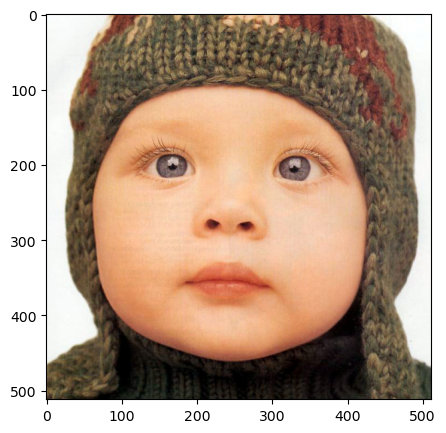

255


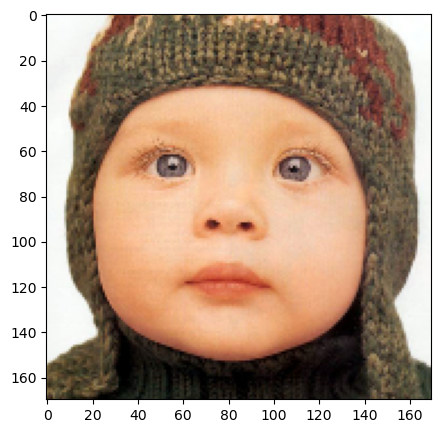

255


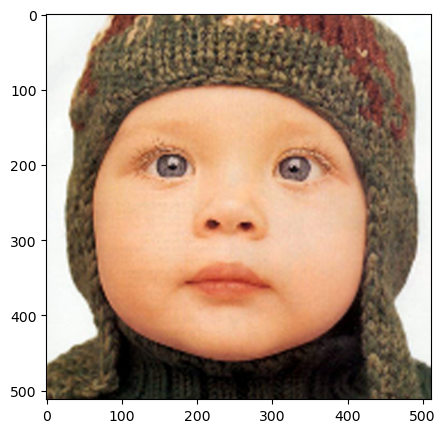

In [242]:
#Original method- OpenCV interpolation (interpolation in "Z" integer space)



img_hr_bgr = cv2.imread('Set5/baby_GT.bmp') #reads as BGR
#if np.max(img_hr_bgr)>1:
#    print(np.max(img_hr_bgr))
#    img_hr_bgr = img_hr_bgr/255.0

Hhr,Whr,C = img_hr_bgr.shape
Hlr = int(Hhr/zooming)
Wlr = int(Whr/zooming)

img_hr_rgb = img_hr_bgr.copy()
img_hr_rgb[:,:,0] = img_hr_bgr[:,:,2]
img_hr_rgb[:,:,2] = img_hr_bgr[:,:,0]

img_hr_ycrcb = cv2.cvtColor(img_hr_bgr,cv2.COLOR_BGR2YCrCb)
img_hr_y = img_hr_ycrcb[:,:,0]
img_hr_cr = img_hr_ycrcb[:,:,1]
img_hr_cb = img_hr_ycrcb[:,:,2]

img_lr_y = cv2.resize(img_hr_y,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cr = cv2.resize(img_hr_cr,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cb = cv2.resize(img_hr_cb,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)

img_lr_ycrcb = np.stack((img_lr_y,img_lr_cr,img_lr_cb),axis=2)

img_lr_bgr = cv2.cvtColor(img_lr_ycrcb,cv2.COLOR_YCrCb2BGR)
img_lr_rgb = img_lr_bgr.copy()
img_lr_rgb[:,:,0] = img_lr_bgr[:,:,2]
img_lr_rgb[:,:,2] = img_lr_bgr[:,:,0]

img_sr_rgb = cv2.resize(img_lr_rgb,dsize=(Hhr,Whr),interpolation=cv2.INTER_CUBIC)
psnr_rgb = calculate_psnr(img_hr_rgb,img_sr_rgb)
print("psnr_rgb = %f"%psnr_rgb)

show_image(img_hr_rgb)
show_image(img_lr_rgb)
show_image(img_sr_rgb)


255
psnr_rgb = 31.752281
255


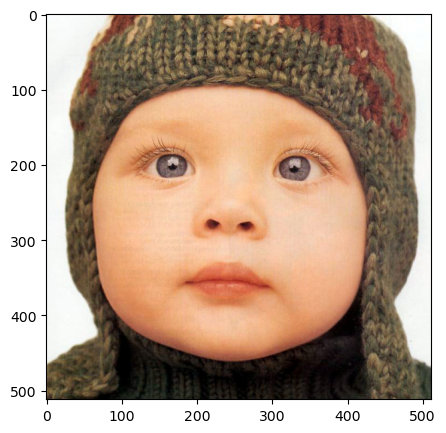

255


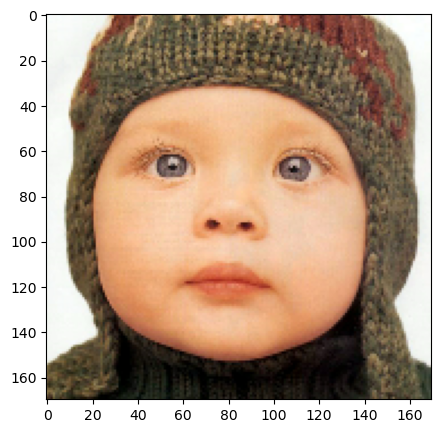

255


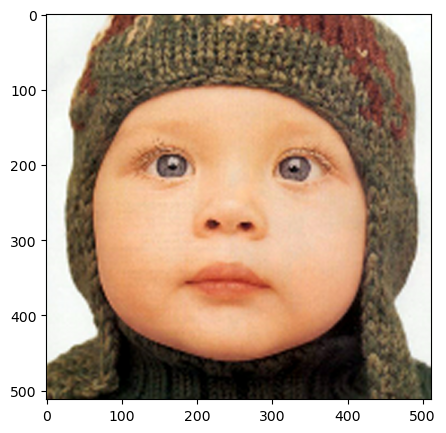

In [246]:
#OpenCV interpolation (interpolation in "R" continuous space)

yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']

img_hr_bgr = cv2.imread('Set5/baby_GT.bmp') #reads as BGR
if np.max(img_hr_bgr)>1:
    print(np.max(img_hr_bgr))
    img_hr_bgr = img_hr_bgr/255.0

Hhr,Whr,C = img_hr_bgr.shape
Hlr = int(Hhr/zooming)
Wlr = int(Whr/zooming)

img_hr_rgb = img_hr_bgr.copy()
img_hr_rgb[:,:,0] = img_hr_bgr[:,:,2]
img_hr_rgb[:,:,2] = img_hr_bgr[:,:,0]

img_hr_ycrcb = cv2.cvtColor((img_hr_bgr*255.0).astype(np.uint8),cv2.COLOR_BGR2YCrCb)/255.0
img_hr_y = img_hr_ycrcb[:,:,0]
img_hr_cr = img_hr_ycrcb[:,:,1]
img_hr_cb = img_hr_ycrcb[:,:,2]

img_lr_y = cv2.resize(img_hr_y,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cr = cv2.resize(img_hr_cr,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cb = cv2.resize(img_hr_cb,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)

img_lr_ycrcb = np.stack((img_lr_y,img_lr_cr,img_lr_cb),axis=2)

img_lr_bgr = cv2.cvtColor((img_lr_ycrcb*255.0).astype(np.uint8),cv2.COLOR_YCrCb2BGR)/255.0
img_lr_rgb = img_lr_bgr.copy()
img_lr_rgb[:,:,0] = img_lr_bgr[:,:,2]
img_lr_rgb[:,:,2] = img_lr_bgr[:,:,0]

img_sr_rgb = cv2.resize(img_lr_rgb,dsize=(Hhr,Whr),interpolation=cv2.INTER_CUBIC)
psnr_rgb = calculate_psnr(img_hr_rgb*255.0,img_sr_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb)

show_image(np.clip((img_hr_rgb*255.0),0,255).astype(np.uint8))
show_image(np.clip((img_lr_rgb*255.0),0,255).astype(np.uint8))
show_image(np.clip((img_sr_rgb*255.0),0,255).astype(np.uint8))


In [ ]:
#(+) Scipy interpolation (Check if there's any difference with the OpenCV interpolation function)

yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary.mat')
dict_hires = yima_dict['Dh']
dict_lores = yima_dict['Dl']

img_hr_bgr = cv2.imread('Set5/baby_GT.bmp') #reads as BGR
if np.max(img_hr_bgr)>1:
    print(np.max(img_hr_bgr))
    img_hr_bgr = img_hr_bgr/255.0

Hhr,Whr,C = img_hr_bgr.shape
Hlr = int(Hhr/zooming)
Wlr = int(Whr/zooming)

img_hr_rgb = img_hr_bgr.copy()
img_hr_rgb[:,:,0] = img_hr_bgr[:,:,2]
img_hr_rgb[:,:,2] = img_hr_bgr[:,:,0]

img_hr_ycrcb = cv2.cvtColor((img_hr_bgr*255.0).astype(np.uint8),cv2.COLOR_BGR2YCrCb)/255.0
img_hr_y = img_hr_ycrcb[:,:,0]
img_hr_cr = img_hr_ycrcb[:,:,1]
img_hr_cb = img_hr_ycrcb[:,:,2]

img_lr_y = cv2.resize(img_hr_y,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cr = cv2.resize(img_hr_cr,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)
img_lr_cb = cv2.resize(img_hr_cb,dsize=(Hlr,Wlr),interpolation=cv2.INTER_CUBIC)

img_lr_ycrcb = np.stack((img_lr_y,img_lr_cr,img_lr_cb),axis=2)

img_lr_bgr = cv2.cvtColor((img_lr_ycrcb*255.0).astype(np.uint8),cv2.COLOR_YCrCb2BGR)/255.0
img_lr_rgb = img_lr_bgr.copy()
img_lr_rgb[:,:,0] = img_lr_bgr[:,:,2]
img_lr_rgb[:,:,2] = img_lr_bgr[:,:,0]

img_sr_rgb = cv2.resize(img_lr_rgb,dsize=(Hhr,Whr),interpolation=cv2.INTER_CUBIC)
psnr_rgb = calculate_psnr(img_hr_rgb*255.0,img_sr_rgb*255.0)
print("psnr_rgb = %f"%psnr_rgb)

show_image((img_hr_rgb*255.0).astype(np.uint8))
show_image((img_lr_rgb*255.0).astype(np.uint8))
show_image((img_sr_rgb*255.0).astype(np.uint8))


In [255]:
#L1SR

#temporarily upsample by a factor of 2 via bicubic interpolation
#"mr" = medium resolution
#if np.max(img_hr_bgr)>1:
#    print(np.max(img_hr_bgr))
#    img_hr_bgr = img_hr_bgr/255.0

Hmr = Hlr*2
Wmr = Wlr*2
img_mr_y = cv2.resize(img_lr_y,dsize=(Hmr,Wmr),interpolation=cv2.INTER_CUBIC)

#show_image(img_hr_y)
#show_image(img_mr_y)

hpatch_size = patch_size*zooming
mpatch_size = patch_size*2

# extract gradient feature from lIm
hf1 = np.array([[-1,0,1]])
vf1 = np.array([[-1,0,1]]).T
hf2 = np.array([[1,0,-2,0,1]])
vf2 = np.array([[1,0,-2,0,1]]).T

img_lr_G11 = scipy.signal.convolve2d(img_mr_y,hf1,mode='same')
img_lr_G12 = scipy.signal.convolve2d(img_mr_y,vf1,mode='same')
img_lr_G21 = scipy.signal.convolve2d(img_mr_y,hf2,mode='same')
img_lr_G22 = scipy.signal.convolve2d(img_mr_y,vf2,mode='same')


img_lr_feat = np.stack((img_lr_G11,img_lr_G12,img_lr_G21,img_lr_G22),axis=2)




In [335]:
#y = img_lr_feat[1:7,1:7].flatten('F')
#y = img_lr_feat[101:107,101:107].flatten('F')
y = img_lr_feat[201:207,201:207].flatten('F')
y_norm = np.sqrt(np.sum(np.dot(y,y)))
if y_norm>1:
    y/=y_norm

In [336]:
D = dict_lores.shape[1]
lasso = Lasso(alpha=1e-5, fit_intercept=False, random_state=0, max_iter=10000)
lasso.fit(dict_lores,y)
w = lasso.coef_
zero_norm = np.matmul(np.where(np.abs(w)>0,1,0),np.ones(D))
print(zero_norm)

49.0


In [332]:
lasso.intercept_

0.0

In [324]:
y_pred = np.matmul(dict_lores,w)

In [325]:
y

array([-4.73619938e-04,  7.86405628e-04,  6.95759448e-04, -7.35212120e-04,
       -7.81779182e-04,  5.62287814e-04, -5.28258327e-04,  7.69736865e-04,
        7.05051480e-04, -7.27875416e-04, -7.48764445e-04,  6.34275988e-04,
       -3.07777247e-04,  1.85796541e-04,  2.29585443e-04, -2.17215316e-04,
       -1.60320399e-04,  3.62222905e-04,  5.18379689e-04,  3.88244038e-06,
       -6.03454937e-05,  3.79374744e-04,  2.95697987e-04, -2.55697174e-04,
        1.52913782e-03,  3.19346836e-04, -2.21463388e-05,  7.38746478e-04,
        3.59666890e-04, -9.29960775e-04,  1.53004713e-03,  3.47268825e-04,
        1.36833800e-04,  1.05588783e-03,  8.48244794e-04, -3.44342895e-04,
        3.95548000e-04,  6.06442242e-04,  6.31340844e-04,  6.34220742e-04,
        6.18427905e-04,  3.09327985e-04,  1.64594546e-03,  1.33399128e-03,
       -3.15980893e-04, -2.85653682e-04,  1.42573956e-03,  1.40432302e-03,
        2.46596616e-03,  1.83975205e-03, -8.66271437e-04, -8.19595183e-04,
        1.98057931e-03,  

In [326]:
y_pred

array([-6.39600710e-03,  5.07356614e-03,  3.62138154e-03,  2.44013009e-03,
       -8.83691626e-04, -4.71742799e-03, -4.80374194e-03,  1.25616547e-03,
        9.01581157e-04,  9.47566102e-04, -2.73291032e-03,  2.29714068e-03,
       -9.63152159e-04,  5.28491689e-04,  1.37743406e-03,  3.47607327e-03,
       -1.19915312e-03,  5.92816308e-04, -3.50626082e-03,  3.30009802e-03,
       -3.15977366e-03,  1.40629419e-03, -9.78001325e-04, -1.84995678e-03,
        1.99089536e-03,  5.45109784e-03, -3.13597766e-05,  2.06863957e-03,
        4.15556595e-03,  2.63854398e-03,  3.14837428e-03, -3.41850816e-03,
        3.73860945e-03, -2.02149768e-03, -2.55409659e-03,  5.87137674e-04,
       -3.17021369e-03,  2.19839676e-04,  3.63057494e-03,  6.68602240e-04,
       -9.61647379e-04,  7.18470311e-04,  4.60830952e-03,  8.76341368e-04,
        1.18624860e-03,  1.02492177e-03,  2.80231560e-03, -3.02264222e-03,
        2.78903833e-03, -1.32800763e-03, -1.18620862e-03, -8.69698978e-04,
        5.13090898e-03,  

In [306]:
D = dict_lores.shape[1]
X_train = dict_lores
y_train = y

alphas = np.logspace(-7, 1, 20)
for i in range(len(alphas)):
    lasso = Lasso(alpha=alphas[i],random_state=0, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_train_pred = np.matmul(X_train,lasso.coef_)
    #y_val_pred = np.matmul(X_val,lasso.coef_)
    r2_train = lasso.score(X_train,y_train)
    #r2_val = lasso.score(X_val,y_val)
    sqloss_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    #sqloss_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    one_norm = np.matmul(np.abs(lasso.coef_),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(lasso.coef_)>0,1,0),np.ones(D))

    #scores.append(r2_val)
    #scores_train_tmp.append(r2_train)
    #scores_val_tmp.append(r2_val)
    #scores_train.append(sqloss_train)
    #scores_val.append(sqloss_val)

    #scores_train_arr[j][i] = r2_train
    #scores_val_arr[j][i] = r2_val

    print(i)
    print(alphas[i])
    #print(lasso.coef_)
    print(r2_train)
    print(one_norm)
    print(zero_norm)
    #print(y_val_pred)
    print("\n")


0
1e-07
0.99998986758761
8.217654115013593
426.0


1
2.6366508987303554e-07
0.9999750841629772
4.960718904050928
180.0


2
6.951927961775605e-07
0.9999166875425779
3.6950517247734846
104.0


3
1.8329807108324375e-06
0.9997468054349324
3.2114689572807795
86.0


4
4.832930238571752e-06
0.9991940264270689
2.6264474157771485
70.0


5
1.274274985703132e-05
0.9981595301134574
2.1918038291215693
57.0


6
3.359818286283781e-05
0.9964198870055895
1.937166743227165
45.0


7
8.858667904100833e-05
0.9925059780922605
1.702543167569751
28.0


8
0.00023357214690901214
0.9835753385085989
1.5113713870569547
19.0


9
0.0006158482110660261
0.9523081835582691
1.2707541501768738
15.0


10
0.001623776739188721
0.804824380769207
0.8365009168755045
4.0


11
0.004281332398719396
0.10585080780258749
0.07640490256252294
2.0


12
0.011288378916846883
0.0
0.0
0.0


13
0.02976351441631313
0.0
0.0
0.0


14
0.07847599703514607
0.0
0.0
0.0


15
0.20691380811147903
0.0
0.0
0.0


16
0.5455594781168515
0.0
0.0
0.0


17
1

In [291]:
dict_lores

array([[ 0.07985276, -0.17480671, -0.00405968, ...,  0.03123815,
        -0.02808419,  0.01296678],
       [ 0.0635118 , -0.14123553, -0.06656984, ...,  0.0252221 ,
         0.01122734,  0.00399028],
       [ 0.02648696, -0.11742768, -0.09830078, ...,  0.03292513,
         0.02667607, -0.0060278 ],
       ...,
       [ 0.05195319,  0.03399506,  0.12841324, ..., -0.00065904,
        -0.03336026,  0.10893914],
       [ 0.10514257,  0.0139234 ,  0.01735056, ...,  0.00717949,
        -0.00143332,  0.33135254],
       [ 0.03915241, -0.03094753, -0.04811025, ..., -0.00371975,
         0.01412315,  0.30488388]])

Lasso(alpha=0.001, max_iter=10000, random_state=0)

array([ 0.,  0.,  0., ...,  0., -0.,  0.])

In [297]:
np.sum(np.abs(lasso.coef_))

1.1832993069955542

In [280]:
dict_lores.shape

(144, 1022)

In [257]:
img_lr_feat.shape

(340, 340, 4)

In [254]:
img_lr_G11.shape

(340, 340)

In [266]:
img_lr_feat[1:7,1:7,0]

array([[-1.63050482e-03, -1.81860534e-03, -1.05956748e-03,
         1.78459671e-03,  5.26427710e-03,  5.26740753e-03],
       [ 2.70731459e-03,  2.64992997e-03,  6.39631342e-04,
         1.33658600e-05,  1.09939746e-03,  1.19552292e-03],
       [ 2.39525207e-03,  2.42724122e-03,  7.90380941e-04,
        -2.07748050e-04, -7.62419598e-05,  4.71070055e-04],
       [-2.53107357e-03, -2.50581591e-03, -7.47794998e-04,
         1.30605217e-03,  2.54324110e-03,  3.63504587e-03],
       [-2.69138738e-03, -2.57772940e-03, -5.51926056e-04,
         1.01798289e-03,  1.23820505e-03,  2.92020482e-03],
       [ 1.93575675e-03,  2.18358640e-03,  1.24700450e-03,
        -8.80274334e-04, -3.20152385e-03, -1.18544999e-03]])

In [269]:
img_lr_feat[1:7,1:7,1]

array([[ 0.00136173,  0.0056664 ,  0.00848944,  0.00838152,  0.00565786,
         0.00171011],
       [ 0.00208776,  0.00459246,  0.00633361,  0.00644241,  0.00434127,
         0.00110189],
       [ 0.00217348, -0.00108781, -0.00298226, -0.00247524, -0.00168958,
        -0.00103139],
       [ 0.0021834 , -0.0009834 , -0.00282157, -0.00232571, -0.00159584,
        -0.00101126],
       [ 0.00212903,  0.00490831,  0.00681843,  0.00690311,  0.0046321 ,
         0.00115835],
       [ 0.00106491,  0.00483458,  0.00723466,  0.00702896,  0.00477061,
         0.00163484]])

In [270]:
img_lr_feat[1:7,1:7,2]

array([[-9.90899652e-01, -5.70937341e-04, -3.60320205e-03,
        -6.32384458e-03, -3.48281082e-03,  3.43223899e-03],
       [-9.94530940e-01,  2.06768325e-03,  2.63656411e-03,
        -4.59766116e-04, -1.18215706e-03,  7.14700530e-04],
       [-9.93057734e-01,  1.60487112e-03,  2.63498927e-03,
         8.66622901e-04, -6.78818105e-04, -1.33276268e-03],
       [-9.87201712e-01, -1.78327857e-03, -3.81186808e-03,
        -3.29103610e-03, -2.32899369e-03, -1.44129485e-03],
       [-9.85869367e-01, -2.13946133e-03, -3.59571229e-03,
        -1.79013111e-03, -1.90222193e-03, -3.95313111e-03],
       [-9.89762087e-01,  6.88752250e-04,  3.06386073e-03,
         4.44852835e-03,  3.05175655e-04, -7.50571609e-03]])

In [271]:
img_lr_feat[1:7,1:7].flatten('F')

array([-1.63050482e-03,  2.70731459e-03,  2.39525207e-03, -2.53107357e-03,
       -2.69138738e-03,  1.93575675e-03, -1.81860534e-03,  2.64992997e-03,
        2.42724122e-03, -2.50581591e-03, -2.57772940e-03,  2.18358640e-03,
       -1.05956748e-03,  6.39631342e-04,  7.90380941e-04, -7.47794998e-04,
       -5.51926056e-04,  1.24700450e-03,  1.78459671e-03,  1.33658600e-05,
       -2.07748050e-04,  1.30605217e-03,  1.01798289e-03, -8.80274334e-04,
        5.26427710e-03,  1.09939746e-03, -7.62419598e-05,  2.54324110e-03,
        1.23820505e-03, -3.20152385e-03,  5.26740753e-03,  1.19552292e-03,
        4.71070055e-04,  3.63504587e-03,  2.92020482e-03, -1.18544999e-03,
        1.36173094e-03,  2.08776472e-03,  2.17348175e-03,  2.18339621e-03,
        2.12902709e-03,  1.06490612e-03,  5.66640419e-03,  4.59245704e-03,
       -1.08780971e-03, -9.83403924e-04,  4.90831369e-03,  4.83458416e-03,
        8.48944351e-03,  6.33361129e-03, -2.98226414e-03, -2.82157441e-03,
        6.81842940e-03,  

In [249]:
img_mr_G11

array([[-9.93242741e-01, -4.20996475e-03, -4.47778259e-03, ...,
         3.96612077e-03,  3.82675922e-03,  9.96651036e-01],
       [-9.92718257e-01, -1.63050482e-03, -1.81860534e-03, ...,
         2.81147875e-03,  2.67731037e-03,  9.97656885e-01],
       [-9.91881010e-01,  2.70731459e-03,  2.64992997e-03, ...,
         9.07956718e-04,  7.84103807e-04,  9.99313580e-01],
       ...,
       [-2.84045837e-01,  6.40521076e-02,  7.59029553e-02, ...,
        -4.76596807e-02, -5.52521970e-02,  2.63976008e-01],
       [-2.43551947e-01,  2.12499202e-02,  4.83491907e-02, ...,
        -4.23007817e-02, -5.02590935e-02,  2.56876644e-01],
       [-2.18151421e-01, -5.10952026e-03,  3.14556610e-02, ...,
        -3.89569595e-02, -4.72012269e-02,  2.52517547e-01]])

In [220]:
(img_mr_y/255.0)[-10:]

array([[0.36470588, 0.34901961, 0.32156863, ..., 0.29019608, 0.2627451 ,
        0.24705882],
       [0.41176471, 0.40784314, 0.40392157, ..., 0.29019608, 0.27843137,
        0.26666667],
       [0.44313725, 0.43921569, 0.43529412, ..., 0.27843137, 0.28627451,
        0.29411765],
       ...,
       [0.30588235, 0.28235294, 0.24313725, ..., 0.23137255, 0.2627451 ,
        0.28235294],
       [0.25098039, 0.24313725, 0.23137255, ..., 0.22745098, 0.25882353,
        0.2745098 ],
       [0.21568627, 0.21960784, 0.22352941, ..., 0.22352941, 0.25098039,
        0.27058824]])

In [221]:
(img_mr_G11/255.0)[-10:]

array([[-0.34901961,  0.04313725,  0.03529412, ...,  0.01176471,
         0.04313725,  0.2627451 ],
       [-0.40784314,  0.00784314,  0.00784314, ..., -0.01176471,
         0.02352941,  0.27843137],
       [-0.43921569,  0.00784314,  0.00392157, ..., -0.03529412,
        -0.01568627,  0.28627451],
       ...,
       [-0.28235294,  0.0627451 ,  0.0745098 , ..., -0.04705882,
        -0.05098039,  0.2627451 ],
       [-0.24313725,  0.01960784,  0.04705882, ..., -0.04313725,
        -0.04705882,  0.25882353],
       [-0.21960784, -0.00784314,  0.03137255, ..., -0.03921569,
        -0.04705882,  0.25098039]])

In [179]:
vf2

array([[ 1],
       [ 0],
       [-2],
       [ 0],
       [ 1]])

In [177]:
scipy.signal.convolve2d(np.array([[1,2,3]]),np.array([[0,1,0.5]]),mode='same')

array([[1. , 2.5, 4. ]])

In [59]:
yima_dict = scipy.io.loadmat('CVPR08-SR/Data/Dictionary/Dictionary4.mat')

In [62]:
yima_dict['Dl'].shape

(144, 1024)